# Testing Full Data — V-JEPA2 ViT-L Embeddings (525K)

Validate the full extraction + Parquet conversion pipeline:
1. Load all 10 Parquet shards and verify 525,328 rows
2. Check metadata completeness (subject_id, study_id, acquisition_datetime, etc.)
3. Embedding health checks (finite, no NaN, no zero vectors)
4. Basic statistics and distributions
5. Cosine similarity analysis (random sample)
6. PCA projection

In [1]:
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib
from pathlib import Path
from sklearn.decomposition import PCA

matplotlib.rcParams["figure.dpi"] = 120

PARQUET_DIR = Path("/orcd/pool/006/lceli_shared/jepa-embeddings-mimiciv-echo/mimic-iv-echo-jepa-embeddings/jepa-l-embeddings")
print(f"Parquet dir: {PARQUET_DIR}")

Parquet dir: /orcd/pool/006/lceli_shared/jepa-embeddings-mimiciv-echo/mimic-iv-echo-jepa-embeddings/jepa-l-embeddings


## 1. Load all shards

In [2]:
shards = sorted(PARQUET_DIR.glob("train-*.parquet"))
print(f"Found {len(shards)} shards:\n")
total_bytes = 0
for s in shards:
    size = s.stat().st_size
    total_bytes += size
    print(f"  {s.name:40s}  {size / 1e6:.0f} MB")
print(f"\nTotal: {total_bytes / 1e9:.2f} GB")

Found 10 shards:

  train-00000-of-00010.parquet              211 MB
  train-00001-of-00010.parquet              214 MB
  train-00002-of-00010.parquet              204 MB
  train-00003-of-00010.parquet              245 MB
  train-00004-of-00010.parquet              204 MB
  train-00005-of-00010.parquet              235 MB
  train-00006-of-00010.parquet              205 MB
  train-00007-of-00010.parquet              223 MB
  train-00008-of-00010.parquet              210 MB
  train-00009-of-00010.parquet              218 MB

Total: 2.17 GB


In [3]:
table = pq.read_table(PARQUET_DIR)
df = table.to_pandas()
print(f"Rows:    {len(df):,}")
print(f"Columns: {list(df.columns)}")
print(f"\nSchema:")
print(table.schema)
print(f"\nExpected: 525,328 rows")
assert len(df) == 525328, f"Row count mismatch: {len(df)} != 525328"
print("PASS")

Rows:    525,328
Columns: ['subject_id', 'study_id', 'dicom_id', 'file_path', 'acquisition_datetime', 'study_datetime', 'note_id', 'note_seq', 'note_charttime', 'embedding']

Schema:
subject_id: int64
study_id: int64
dicom_id: string
file_path: string
acquisition_datetime: string
study_datetime: string
note_id: string
note_seq: string
note_charttime: string
embedding: fixed_size_list<element: float>[1024]
  child 0, element: float

Expected: 525,328 rows
PASS


In [4]:
df.head(3)

,subject_id,study_id,dicom_id,file_path,acquisition_datetime,study_datetime,note_id,note_seq,note_charttime,embedding
0,10002221,94106955,94106955_0001,p10002221/s94106955/94106955_0001.mp4,2204-10-03 13:14:42,2204-10-03 08:13:32,NaN,NaN,NaN,"[0.27315545, -0.59520245, 0.39154857, 0.602460..."
1,10002221,94106955,94106955_0006,p10002221/s94106955/94106955_0006.mp4,2204-10-03 13:17:40,2204-10-03 08:13:32,NaN,NaN,NaN,"[0.17233324, -0.3031202, 0.0949621, 0.8385732,..."
2,10002221,94106955,94106955_0007,p10002221/s94106955/94106955_0007.mp4,2204-10-03 13:18:03,2204-10-03 08:13:32,NaN,NaN,NaN,"[0.11805265, -0.53636813, 0.3988374, 0.5299602..."


## 2. Metadata completeness

In [5]:
meta_cols = ["subject_id", "study_id", "dicom_id", "file_path",
             "acquisition_datetime", "study_datetime",
             "note_id", "note_seq", "note_charttime"]

print(f"{'Column':<25s} {'Non-null':>10s} {'Null':>8s} {'Coverage':>10s}")
print("-" * 55)
for col in meta_cols:
    non_null = df[col].notna().sum()
    null = df[col].isna().sum()
    pct = 100 * non_null / len(df)
    print(f"{col:<25s} {non_null:>10,d} {null:>8,d} {pct:>9.1f}%")

print(f"\nUnique subjects: {df['subject_id'].nunique():,}")
print(f"Unique studies:  {df['study_id'].nunique():,}")
print(f"Unique videos:   {df['file_path'].nunique():,}")

Column                      Non-null     Null   Coverage
-------------------------------------------------------
subject_id                   525,328        0     100.0%
study_id                     525,328        0     100.0%
dicom_id                     525,328        0     100.0%
file_path                    525,328        0     100.0%
acquisition_datetime         525,319        9     100.0%
study_datetime               525,319        9     100.0%
note_id                       64,662  460,666      12.3%
note_seq                      64,662  460,666      12.3%
note_charttime                64,662  460,666      12.3%

Unique subjects: 4,585
Unique studies:  7,251
Unique videos:   525,328


## 3. Embedding health checks

In [5]:
# Convert embeddings to numpy matrix
embeddings = np.stack(df["embedding"].values)
print(f"Embedding matrix shape: {embeddings.shape}")
print(f"Dtype: {embeddings.dtype}")
print(f"Memory: {embeddings.nbytes / 1e9:.2f} GB")

print(f"\n--- Health Checks ---")
print(f"All finite:     {np.isfinite(embeddings).all()}")
print(f"Any NaN:        {np.isnan(embeddings).any()}")
print(f"Any Inf:        {np.isinf(embeddings).any()}")
zero_vecs = (np.abs(embeddings).sum(axis=1) == 0).sum()
print(f"Zero vectors:   {zero_vecs}")

assert np.isfinite(embeddings).all(), "Non-finite values found!"
assert zero_vecs == 0, "Zero vectors found!"
print("\nAll health checks PASSED")

Embedding matrix shape: (525328, 1024)
Dtype: float32
Memory: 2.15 GB

--- Health Checks ---
All finite:     True
Any NaN:        False
Any Inf:        False
Zero vectors:   0

All health checks PASSED


## 4. Basic statistics

In [7]:
print(f"--- Global Statistics ---")
print(f"Mean:           {embeddings.mean():.6f}")
print(f"Std:            {embeddings.std():.6f}")
print(f"Min:            {embeddings.min():.6f}")
print(f"Max:            {embeddings.max():.6f}")

norms = np.linalg.norm(embeddings, axis=1)
print(f"\n--- L2 Norms ---")
print(f"Mean norm:      {norms.mean():.4f}")
print(f"Std norm:       {norms.std():.4f}")
print(f"Min norm:       {norms.min():.4f}")
print(f"Max norm:       {norms.max():.4f}")

dim_stds = embeddings.std(axis=0)
print(f"\n--- Per-Dimension ---")
print(f"Dead dims (std<1e-6): {(dim_stds < 1e-6).sum()}")
print(f"Dim std range:  [{dim_stds.min():.4f}, {dim_stds.max():.4f}]")

--- Global Statistics ---
Mean:           0.021698
Std:            1.923113
Min:            -32.900612
Max:            19.694672

--- L2 Norms ---
Mean norm:      61.3146
Std norm:       5.3037
Min norm:       51.9891
Max norm:       74.5919

--- Per-Dimension ---
Dead dims (std<1e-6): 0
Dim std range:  [0.0989, 5.8828]


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# (a) Histogram of embedding values (sample 1M values for speed)
sample_vals = embeddings.flatten()
if len(sample_vals) > 1_000_000:
    sample_vals = np.random.choice(sample_vals, 1_000_000, replace=False)
axes[0].hist(sample_vals, bins=100, color="steelblue", edgecolor="none", alpha=0.8)
axes[0].set_xlabel("Value")
axes[0].set_ylabel("Count")
axes[0].set_title("Embedding value distribution (1M sample)")
axes[0].axvline(0, color="red", linestyle="--", linewidth=0.8)

# (b) L2 norm distribution
axes[1].hist(norms, bins=100, color="coral", edgecolor="none", alpha=0.8)
axes[1].set_xlabel("L2 Norm")
axes[1].set_ylabel("Count")
axes[1].set_title(f"L2 norm distribution (mean={norms.mean():.1f})")

# (c) Per-dimension std
axes[2].plot(sorted(dim_stds, reverse=True), color="green", linewidth=0.8)
axes[2].set_xlabel("Dimension (sorted)")
axes[2].set_ylabel("Std")
axes[2].set_title("Per-dimension std (sorted desc)")

plt.suptitle(f"V-JEPA2 ViT-L Embeddings — {len(embeddings):,} videos", fontsize=12, fontweight="bold")
plt.tight_layout()
plt.show()

## 5. Cosine similarity (random sample)

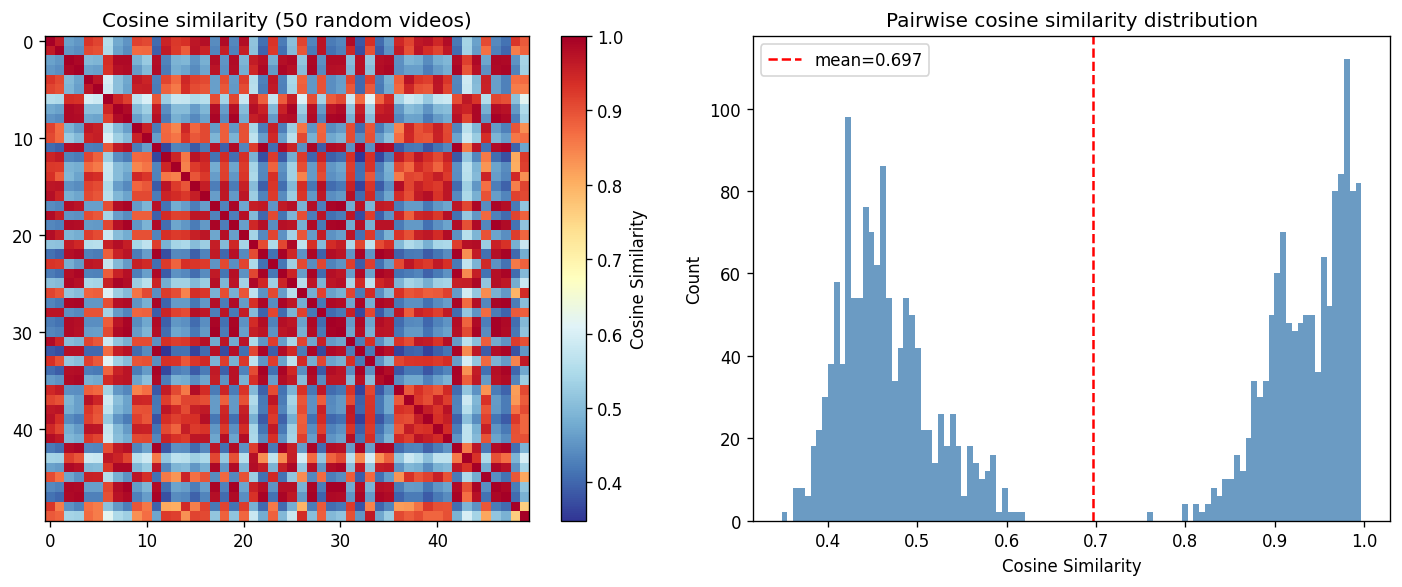

Off-diagonal cosine similarity:
  Mean: 0.6972
  Std:  0.2413
  Min:  0.3485
  Max:  0.9970


In [6]:
# Sample 500 random embeddings for cosine similarity analysis
np.random.seed(42)
sample_idx = np.random.choice(len(embeddings), min(50, len(embeddings)), replace=False)
sample_embs = embeddings[sample_idx]

# Normalize
normed = sample_embs / np.linalg.norm(sample_embs, axis=1, keepdims=True)
sim_matrix = normed @ normed.T

# Off-diagonal
mask = ~np.eye(len(sample_idx), dtype=bool)
off_diag = sim_matrix[mask]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# (a) Similarity heatmap
im = axes[0].imshow(sim_matrix, cmap="RdYlBu_r", vmin=off_diag.min(), vmax=1.0)
plt.colorbar(im, ax=axes[0], label="Cosine Similarity")
axes[0].set_title(f"Cosine similarity ({len(sample_idx)} random videos)")

# (b) Off-diagonal distribution
axes[1].hist(off_diag, bins=100, color="steelblue", edgecolor="none", alpha=0.8)
axes[1].axvline(off_diag.mean(), color="red", linestyle="--", label=f"mean={off_diag.mean():.3f}")
axes[1].set_xlabel("Cosine Similarity")
axes[1].set_ylabel("Count")
axes[1].set_title("Pairwise cosine similarity distribution")
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Off-diagonal cosine similarity:")
print(f"  Mean: {off_diag.mean():.4f}")
print(f"  Std:  {off_diag.std():.4f}")
print(f"  Min:  {off_diag.min():.4f}")
print(f"  Max:  {off_diag.max():.4f}")

## 6. PCA projection

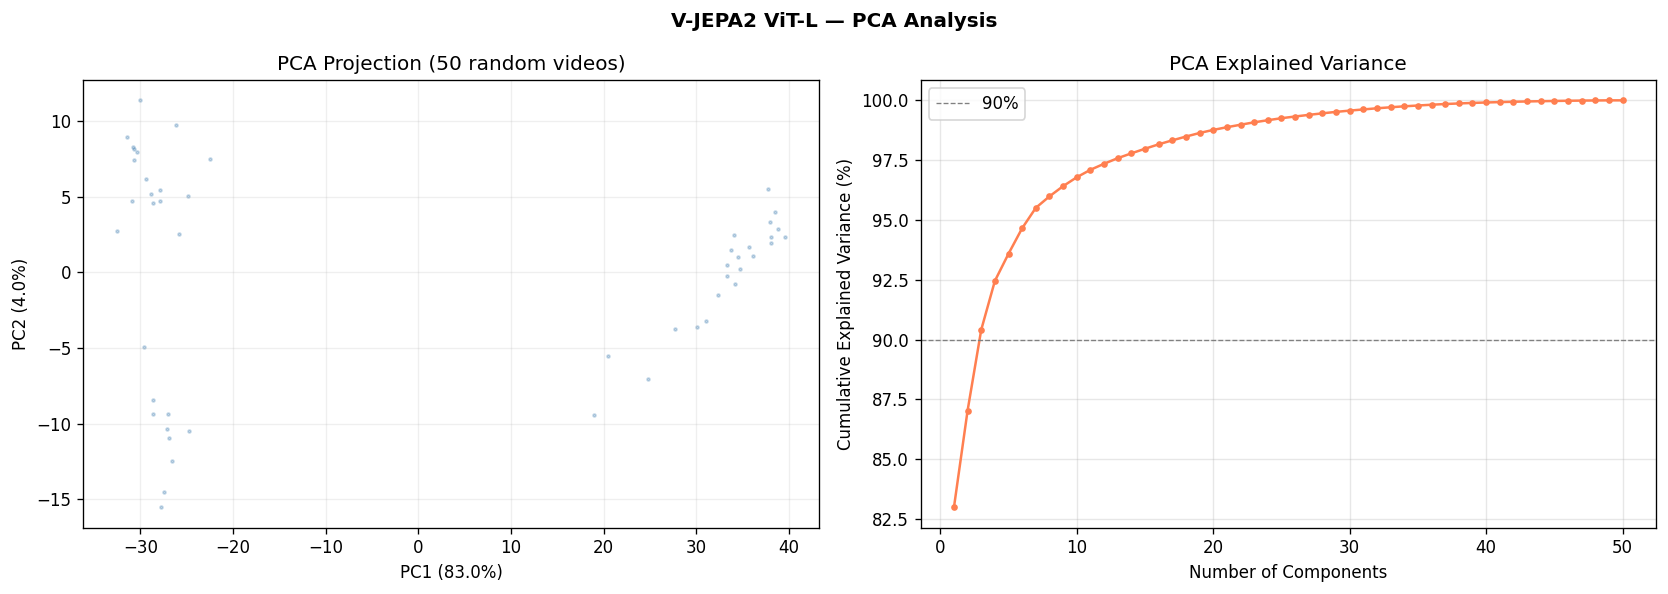

Components for 90% variance: 3
PC1: 83.0%, PC2: 4.0%


In [7]:
# Use 5000 random samples for PCA visualization
np.random.seed(42)
n_pca = min(50, len(embeddings))
pca_idx = np.random.choice(len(embeddings), n_pca, replace=False)
pca_embs = embeddings[pca_idx]

pca = PCA(n_components=50)
proj = pca.fit_transform(pca_embs)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# (a) 2D scatter
axes[0].scatter(proj[:, 0], proj[:, 1], s=3, alpha=0.3, c="steelblue")
axes[0].set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
axes[0].set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
axes[0].set_title(f"PCA Projection ({n_pca:,} random videos)")
axes[0].grid(True, alpha=0.2)

# (b) Cumulative explained variance
cumvar = np.cumsum(pca.explained_variance_ratio_) * 100
axes[1].plot(range(1, 51), cumvar, "o-", markersize=3, color="coral")
axes[1].set_xlabel("Number of Components")
axes[1].set_ylabel("Cumulative Explained Variance (%)")
axes[1].set_title("PCA Explained Variance")
axes[1].grid(True, alpha=0.3)
axes[1].axhline(90, color="gray", linestyle="--", linewidth=0.8, label="90%")
axes[1].legend()

plt.suptitle("V-JEPA2 ViT-L — PCA Analysis", fontsize=12, fontweight="bold")
plt.tight_layout()
plt.show()

# How many PCs for 90% variance?
n_90 = np.searchsorted(cumvar, 90) + 1
print(f"Components for 90% variance: {n_90}")
print(f"PC1: {pca.explained_variance_ratio_[0]*100:.1f}%, PC2: {pca.explained_variance_ratio_[1]*100:.1f}%")

## 7. Per-shard summary

In [8]:
# Verify per-shard counts match expected folder sizes
expected = {
    0: ("p10", 51176), 1: ("p11", 51816), 2: ("p12", 49299),
    3: ("p13", 59253), 4: ("p14", 49431), 5: ("p15", 56970),
    6: ("p16", 49635), 7: ("p17", 54047), 8: ("p18", 50965),
    9: ("p19", 52736),
}

rows = []
for i, shard_path in enumerate(shards):
    t = pq.read_table(shard_path)
    folder, exp_count = expected[i]
    actual = t.num_rows
    match = "PASS" if actual == exp_count else f"FAIL (expected {exp_count})"
    size_mb = shard_path.stat().st_size / 1e6
    rows.append({
        "Shard": shard_path.name,
        "Folder": folder,
        "Rows": f"{actual:,}",
        "Expected": f"{exp_count:,}",
        "Size (MB)": f"{size_mb:.0f}",
        "Status": match,
    })

summary = pd.DataFrame(rows)
display(summary)

all_pass = all(r["Status"] == "PASS" for r in rows)
print(f"\nAll shards match expected counts: {all_pass}")

,Shard,Folder,Rows,Expected,Size (MB),Status
0,train-00000-of-00010.parquet,p10,"51,176","51,176",211,PASS
1,train-00001-of-00010.parquet,p11,"51,816","51,816",214,PASS
2,train-00002-of-00010.parquet,p12,"49,299","49,299",204,PASS
3,train-00003-of-00010.parquet,p13,"59,253","59,253",245,PASS
4,train-00004-of-00010.parquet,p14,"49,431","49,431",204,PASS
5,train-00005-of-00010.parquet,p15,"56,970","56,970",235,PASS
6,train-00006-of-00010.parquet,p16,"49,635","49,635",205,PASS
7,train-00007-of-00010.parquet,p17,"54,047","54,047",223,PASS
8,train-00008-of-00010.parquet,p18,"50,965","50,965",210,PASS
9,train-00009-of-00010.parquet,p19,"52,736","52,736",218,PASS



All shards match expected counts: True
